# Случайные леса
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][MS][HW09] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом задании вам предстоит реализовать ансамбль деревьев решений, известный как случайный лес, применить его к публичным данным пользователей социальной сети Вконтакте, и сравнить его эффективность с ансамблем, предоставляемым библиотекой CatBoost.

В результате мы сможем определить, какие подписки пользователей больше всего влияют на определение возраста и пола человека. 

In [1]:
! pip install catboost

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas
import scipy.stats as st
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import seaborn as sns
from catboost import CatBoostClassifier
from collections import Counter, defaultdict
from typing import Callable, Union, NoReturn, Optional, Dict, Any, List, Iterable

In [3]:
SEED = 42
np.random.seed(SEED)

### Задание 1 (2 балла)
Random Forest состоит из деревьев решений. Каждое такое дерево строится на одной из выборок, полученных при помощи bagging. Элементы, которые не вошли в новую обучающую выборку, образуют out-of-bag выборку. Кроме того, в каждом узле дерева мы случайным образом выбираем набор из `max_features` и ищем признак для предиката разбиения только в этом наборе.

Сегодня мы будем работать только с бинарными признаками, поэтому нет необходимости выбирать значение признака для разбиения.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

#### Параметры конструктора
`X, y` - обучающая выборка и соответствующие ей метки классов. Из нее нужно получить выборку для построения дерева при помощи bagging. Out-of-bag выборку нужно запомнить, она понадобится потом.

`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

`max_features="auto"` - количество признаков, которые могут использоваться в узле. Если `"auto"` - равно `sqrt(X.shape[1])`

In [4]:
def gini(x):
    _, counts = np.unique(x, return_counts=True)
    probs = counts / len(x)
    return probs @ (1. - probs)
    
def entropy(x):
    _, counts = np.unique(x, return_counts=True)
    probs = counts / len(x)
    return -(probs @ np.log2(probs))

def gain(left_y, right_y, criterion):
    n = len(left_y) + len(right_y)
    return criterion(np.hstack([left_y, right_y])) \
           - len(left_y) * criterion(left_y) / n \
           - len(right_y) * criterion(right_y) / n

In [5]:
class DecisionTreeLeaf:
    def __init__(self, y):
        counter = Counter(y)
        self.y = counter.most_common(1)[0][0]
        n = len(y)
        self.probs = {label: count / n for label, count in counter.items()}


class DecisionTreeNode:
    def __init__(self,
                 split_dim: int,
                 left: Union['DecisionTreeNode', DecisionTreeLeaf],
                 right: Union['DecisionTreeNode', DecisionTreeLeaf]):
        self.split_dim = split_dim
        self.left = left
        self.right = right

In [6]:
# немного измененный класс из прошлой домашки
class DecisionTree:
    def __init__(self,
                 X,
                 y,
                 criterion: str = "gini",
                 max_depth: Optional[int] = None,
                 min_samples_leaf: int = 1,
                 max_features="auto"):

        self.root = None
        self.classes = None
        if max_depth is not None and max_depth < 1:
            raise ValueError("max_depth must be None or >= 1")
        self.max_depth = max_depth
        if min_samples_leaf < 1:
            raise ValueError("min_samples_leaf must be >= 1")
        self.min_samples_leaf = min_samples_leaf
        if max_features == "auto":
            self.max_features = int(np.sqrt(X.shape[1]))
        else:
            self.max_features = max_features
        self.criterion = self._get_criterion(criterion)
        bagging_indexes = np.random.choice(X.shape[0], X.shape[0], replace=True)
        self.X, self.y = X[bagging_indexes], y[bagging_indexes]
        self.oob_X = np.delete(X, bagging_indexes, axis=0)
        self.oob_y = np.delete(y, bagging_indexes)
        self.fit(self.X, self.y)

    def _get_criterion(self, criterion: str) -> Callable:
        if criterion == "gini":
            return gini
        elif criterion == "entropy":
            return entropy
        else:
            raise NotImplementedError("criterion must be 'gini' or 'entropy'")

    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        def build_tree_node(X_node: np.ndarray,
                            y_node: np.ndarray,
                            depth: int = 1
                            ) -> Union[DecisionTreeNode, DecisionTreeLeaf]:
            if self.max_depth is not None and depth >= self.max_depth:
                return DecisionTreeLeaf(y_node)

            n_samples, n_features = X_node.shape
            best_split_dim = None
            best_gain = 0.

            features = np.random.choice(n_features, self.max_features, replace=False)

            for split_dim in features:
                left_mask = ~X_node[:, split_dim].astype(bool)
                left_size = sum(left_mask)
                if left_size >= self.min_samples_leaf and n_samples - left_size >= self.min_samples_leaf:
                    gain_value = gain(y_node[left_mask], y_node[~left_mask], criterion=self.criterion)
                    if gain_value > best_gain:
                        best_split_dim = split_dim
                        best_gain = gain_value

            if best_split_dim is None:
                return DecisionTreeLeaf(y_node)

            left_mask = ~X_node[:, best_split_dim].astype(bool)
            left_node = build_tree_node(X_node[left_mask], y_node[left_mask], depth + 1)
            right_node = build_tree_node(X_node[~left_mask], y_node[~left_mask], depth + 1)
            return DecisionTreeNode(best_split_dim, left_node, right_node)

        self.root = build_tree_node(X, y, 1)

    def predict_proba(self, X: np.ndarray) -> Iterable[Dict[Any, float]]:
        def tree_walk(X_node: np.ndarray, node: Union[DecisionTreeLeaf, DecisionTreeNode]) -> Iterable[
            Dict[Any, float]]:
            result = np.empty(X_node.shape[0], dtype=np.object)
            if isinstance(node, DecisionTreeLeaf):
                result[:] = np.copy(node.probs)
            else:
                left_mask = ~X_node[:, node.split_dim].astype(bool)
                result[left_mask] = tree_walk(X_node[left_mask], node.left)
                result[~left_mask] = tree_walk(X_node[~left_mask], node.right)
            return result

        return tree_walk(X, self.root)

    def predict(self, X: np.ndarray) -> list:
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

### Задание 2 (2 балла)
Теперь реализуем сам Random Forest. Идея очень простая: строим `n` деревьев, а затем берем модальное предсказание.

#### Параметры конструктора
`n_estimators` - количество используемых для предсказания деревьев.

Остальное - параметры деревьев.

#### Методы
`fit(X, y)` - строит `n_estimators` деревьев по выборке `X`.

`predict(X)` - для каждого элемента выборки `X` возвращает самый частый класс, который предсказывают для него деревья.

In [7]:
class RandomForestClassifier:
    def __init__(self,
                 criterion="gini",
                 max_depth=None,
                 min_samples_leaf=1,
                 max_features="auto",
                 n_estimators=10
                 ):
        self.n_estimators = n_estimators
        self.tree_kwargs = {
            "criterion": criterion,
            "max_depth": max_depth,
            "min_samples_leaf": min_samples_leaf,
            "max_features": max_features,
        }
        self.forest = None

    def fit(self, X, y):
        self.n_features = X.shape[1]
        self.forest = [DecisionTree(X, y, **self.tree_kwargs) for i in range(self.n_estimators)]

    def predict(self, X):
        pred = np.array([tree.predict(X) for tree in self.forest])
        return st.mode(pred)[0][0]

### Задание 3 (2 балла)
Часто хочется понимать, насколько большую роль играет тот или иной признак для предсказания класса объекта. Есть различные способы посчитать его важность. Один из простых способов сделать это для Random Forest - посчитать out-of-bag ошибку предсказания `err_oob`, а затем перемешать значения признака `j` и посчитать ее (`err_oob_j`) еще раз. Оценкой важности признака `j` для одного дерева будет разность `err_oob_j - err_oob`, важность для всего леса считается как среднее значение важности по деревьям.

Реализуйте функцию `feature_importance`, которая принимает на вход Random Forest и возвращает массив, в котором содержится важность для каждого признака.

In [8]:
def feature_importance(rfc):
    n_trees, n_features = rfc.n_estimators, rfc.n_features
    importances = np.zeros((n_features, n_trees), dtype=np.float64)

    for tree_num, tree in enumerate(rfc.forest):
        X, y = tree.oob_X, tree.oob_y
        err_oob = np.mean(tree.predict(X) == y)
        for dim in range(n_features):
            shuffled_X = X.copy()
            shuffled_X[:, dim] = np.random.permutation(X[:, dim])
            err_oob_j = np.mean(tree.predict(shuffled_X) == y)
            importances[dim, tree_num] = err_oob - err_oob_j
    return np.mean(importances, axis=1)

def most_important_features(importance, names, k=20):
    # Выводит названия k самых важных признаков
    idicies = np.argsort(importance)[::-1][:k]
    return np.array(names)[idicies]

Наконец, пришло время протестировать наше дерево на простом синтетическом наборе данных. В результате точность должна быть примерно равна `1.0`, наибольшее значение важности должно быть у признака с индексом `4`, признаки с индексами `2` и `3`  должны быть одинаково важны, а остальные признаки - не важны совсем.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Accuracy: 1.0


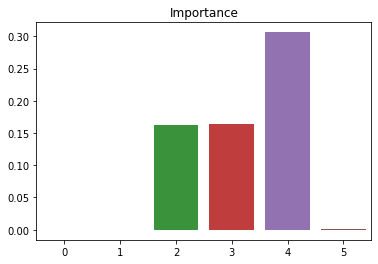

In [9]:
def synthetic_dataset(size):
    X = [(np.random.randint(0, 2), np.random.randint(0, 2), i % 6 == 3, 
          i % 6 == 0, i % 3 == 2, np.random.randint(0, 2)) for i in range(size)]
    y = [i % 3 for i in range(size)]
    return np.array(X), np.array(y)

X, y = synthetic_dataset(1000)
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X, y)
print("Accuracy:", np.mean(rfc.predict(X) == y))

importance = feature_importance(rfc)
sns.barplot(x=list(range(len(importance))), y=importance)
plt.title("Importance")
plt.show()

### Задание 4 (1 балл)
Теперь поработаем с реальными данными.

Выборка состоит из публичных анонимизированных данных пользователей социальной сети Вконтакте. Первые два столбца отражают возрастную группу (`zoomer`, `doomer` и `boomer`) и пол (`female`, `male`). Все остальные столбцы являются бинарными признаками, каждый из них определяет, подписан ли пользователь на определенную группу/публичную страницу или нет.\
\
Необходимо обучить два классификатора, один из которых определяет возрастную группу, а второй - пол.\
\
Эксперименты с множеством используемых признаков и подбор гиперпараметров приветствуются. Лес должен строиться за какое-то разумное время.

In [10]:
def read_dataset(path):
    dataframe = pandas.read_csv(path, header=0)
    dataset = dataframe.values.tolist()
    random.shuffle(dataset)
    y_age = [row[0] for row in dataset]
    y_sex = [row[1] for row in dataset]
    X = [row[2:] for row in dataset]
    
    return np.array(X), np.array(y_age), np.array(y_sex), list(dataframe.columns)[2:]

In [11]:
X, y_age, y_sex, features = read_dataset("vk.csv")
X_train, X_test, y_age_train, y_age_test, y_sex_train, y_sex_test = train_test_split(X, y_age, y_sex, train_size=0.9, random_state=SEED)

In [12]:
df = pandas.read_csv("vk.csv")
print(df.shape)
df.head()

(7924, 151)


,age,sex,s_arcazm,fortnite,ultrapir,homeideaz,ftp_memes,bog_memes,webmland,cook_good,vpisssska,ideasdecor,girlmeme,dzenpub,kinomania,bestad,life,great.food,rapnewrap,medieval_or,authors,pn6,9o_6o_9o,pixel_stickers,40kg,styd.pozor,emptiness,kino_mania,pikabu,v5umm,businessquotes,thesmolny,combovine,1poetry,mayyoung,tysnm,recipes40kg,gm.power,psy.people,overhear,...,dayvinchik,matchtv,femalemem,e_goist,officialpages,iphone,leprazo,sci,peregovorov,kino_kaif,zloyshkolnik,ohhluul,pozor,bot_maxim,pho,club52205838,kinohd,privetuyeba,public_of_music,nenormalnoo,sh.cook,i_want_love_dream,psyxov,iwantyou,modnailru,tnt,ovsyanochan,fucking_humor,zerofat,xfilm,mash,otbrosy_pokoleniya,lomai_loogiky,reflexia_our_feelings,h.made,vandroukiru,ifun,bon,igm,bratishkinoff
0,zoomer,female,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,boomer,female,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,doomer,female,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,zoomer,female,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,boomer,male,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Возраст

In [13]:
rfc = RandomForestClassifier(n_estimators=10)

rfc.fit(X_train, y_age_train)
print("Accuracy:", np.mean(rfc.predict(X_test) == y_age_test))
print("Most important features:")
for i, name in enumerate(most_important_features(feature_importance(rfc), features, 20)):
    print(str(i+1) + ".", name)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Accuracy: 0.7087011349306431
Most important features:
1. ovsyanochan
2. rhymes
3. styd.pozor
4. mudakoff
5. 4ch
6. dayvinchik
7. pravdashowtop
8. rapnewrap
9. iwantyou
10. bot_maxim
11. tumblr_vacuum
12. reflexia_our_feelings
13. pixel_stickers
14. bog_memes
15. soverwenstvo.decora
16. xfilm
17. bestad
18. i_d_t
19. vinevinevine
20. femalemem


#### Пол

In [14]:
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_train, y_sex_train)
print("Accuracy:", np.mean(rfc.predict(X_test) == y_sex_test))
print("Most important features:")
for i, name in enumerate(most_important_features(feature_importance(rfc), features, 20)):
    print(str(i+1) + ".", name)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Accuracy: 0.8575031525851198
Most important features:
1. 40kg
2. girlmeme
3. zerofat
4. modnailru
5. 9o_6o_9o
6. mudakoff
7. igm
8. woman.blog
9. be.women
10. bon
11. thesmolny
12. cook_good
13. be.beauty
14. reflexia_our_feelings
15. 4ch
16. i_d_t
17. soverwenstvo.decora
18. combovine
19. rhymes
20. fuck_humor


### CatBoost
В качестве аьтернативы попробуем CatBoost. 

Устаниовить его можно просто с помощью `pip install catboost`. Туториалы можно найти, например, [здесь](https://catboost.ai/docs/concepts/python-usages-examples.html#multiclassification) и [здесь](https://github.com/catboost/tutorials/blob/master/python_tutorial.ipynb). Главное - не забудьте использовать `loss_function='MultiClass'`.\
\
Сначала протестируйте CatBoost на синтетических данных. Выведите точность и важность признаков.

Accuracy: 1.0


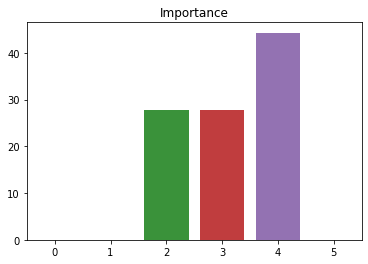

In [15]:
X, y = synthetic_dataset(1000)
catboost = CatBoostClassifier(iterations=100, loss_function="MultiClass", verbose=False)
catboost.fit(X, y)
y_pred = catboost.predict(X).flatten()
print("Accuracy:", np.mean(y_pred == y))

importance = catboost.feature_importances_
sns.barplot(x=list(range(len(importance))), y=importance)
plt.title("Importance")
plt.show()

### Задание 5 (3 балла)
Попробуем применить один из используемых на практике алгоритмов. В этом нам поможет CatBoost. Также, как и реализованный ними RandomForest, применим его для определения пола и возраста пользователей сети Вконтакте, выведите названия наиболее важных признаков так же, как в задании 3.\
\
Эксперименты с множеством используемых признаков и подбор гиперпараметров приветствуются.

In [16]:
X, y_age, y_sex, features = read_dataset("vk.csv")
X_train, X_test, y_age_train, y_age_test, y_sex_train, y_sex_test = train_test_split(X, y_age, y_sex, train_size=0.9)
X_train, X_eval, y_age_train, y_age_eval, y_sex_train, y_sex_eval = train_test_split(X_train, y_age_train, y_sex_train, train_size=0.8)

#### Возраст

In [17]:
catboost_age = CatBoostClassifier(n_estimators=1000, loss_function="MultiClass", verbose=False)
catboost_age.fit(X_train, y_age_train)
y_pred = catboost_age.predict(X_test).flatten()
print("\nAccuracy:", np.mean(y_pred == y_age_test))
print("Most important features:")
for i, name in enumerate(most_important_features(catboost_age.feature_importances_, features, 10)):
    print(str(i+1) + ".", name)


Accuracy: 0.7490542244640606
Most important features:
1. ovsyanochan
2. 4ch
3. styd.pozor
4. mudakoff
5. dayvinchik
6. rhymes
7. rapnewrap
8. leprum
9. fuck_humor
10. xfilm


#### Пол

In [18]:
catboost_sex = CatBoostClassifier(n_estimators=1000, loss_function="MultiClass", verbose=False)
catboost_sex.fit(X_train, y_sex_train)
y_pred = catboost_sex.predict(X_test).flatten()
print("\nAccuracy:", np.mean(y_pred == y_sex_test))
print("Most important features:")
for i, name in enumerate(most_important_features(catboost_sex.feature_importances_, features, 10)):
    print(str(i+1) + ".", name)


Accuracy: 0.8814627994955864
Most important features:
1. 40kg
2. mudakoff
3. girlmeme
4. modnailru
5. i_d_t
6. 4ch
7. femalemem
8. be.beauty
9. igm
10. 9o_6o_9o
